# Duration of Sick Notes and Associated Diagnoses

This notebook provides descriptive statistics (mean and median) of the duration of sick notes and compares diagnoses associated with sick notes across COVID and comparator cohorts.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import seaborn as sns

from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None

In [2]:
# Function to parse string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [3]:
# Read in and append input files
li = []

for file in glob('../output/cohorts/cohort_rates*.dta'):
    df_temp = pd.read_stata(file)
    # Creates date variable based on file name
    df_temp['cohort'] = file[find_nth(file, '_', 2)+1:-4]
    # Create population count
    df_temp['population'] = 1
    li.append(df_temp)
    
df_temp = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

# hospitalised COVID cohort
covid_hosp = df_temp.loc[(~df_temp.hosp_expo_date.isna()) & (df_temp.cohort == 'covid_2020')]
covid_hosp.cohort = 'covid_hosp_2020'
li.append(covid_hosp)

df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [4]:
# Do not count those who had sick notes beyond end dates
df_input.loc[df_input.sick_note == 0, 'first_sick_note_duration'] = np.nan

In [5]:
# Columns to subset
diag_cols = [col for col in df_input if col.startswith('diag_')]
subset_cols = ['cohort','age_group','sex',
               'ethnicity','imd','region_string',
               'first_sick_note_duration',
               'sick_note','population'] + diag_cols

# Subset to relevant columns and do not count those beyond 
df_clean = df_input[subset_cols].rename(columns={'region_string':'region'})

In [6]:
# Nicer names for cohorts 
dict_cohort_names = {'covid_2020':'COVID patients (2020)', 
                     'covid_hosp_2020':'Hospitalised COVID patients (2020)', 
                     'general_2019':'General population (2019)', 
                     'general_2020':'General population (2020)', 
                     'pneumonia_2019':'Hospitalised pneumonia patients (2019)'}
df_clean = df_clean.replace({"cohort": dict_cohort_names})

_____

## Duration

In [7]:
def compute_med_mean(path, demo=''):
    groups = ['cohort']
    if demo != '': 
        groups = ['cohort', demo]
    df_pct_ct = df_clean.groupby(
        groups)[['sick_note','population']].sum().reset_index()
    df_med = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmedian).reset_index().rename(columns={0:'median_duration'})
    df_mean = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(np.nanmean).reset_index().rename(columns={0:'mean_duration'})
    df_pct25 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,25)).reset_index().rename(columns={0:'pct_25'})
    df_pct75 = df_clean.groupby(
        groups)[['first_sick_note_duration']].apply(lambda x: np.nanpercentile(x,75)).reset_index().rename(columns={0:'pct_75'})
    dfs = [df_pct_ct, df_med, df_mean, df_pct25, df_pct75]
    df_out = reduce(
        lambda left,right: pd.merge(left,right,on=groups), dfs
    )
    # Redact if sick notes or population count <= 5 
    df_out = df_out.loc[(df_out['population'] > 5) & (df_out['sick_note'] > 5)]
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    df_out.to_csv('../output/tabfig/' + path + '.csv', index=False)
    return df_out

In [8]:
# Overall
compute_med_mean('med_mean_overall')

,cohort,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),688.0,1294,267.0,269.031977,212.00,314.25
1,General population (2019),395.0,867,272.0,280.365482,224.00,322.00
2,General population (2020),514.0,860,267.0,271.988327,221.25,319.75
3,Hospitalised COVID patients (2020),268.0,498,271.5,268.111940,209.00,310.00
4,Hospitalised pneumonia patients (2019),194.0,471,272.0,277.314433,223.25,326.00


In [9]:
# Age group
compute_med_mean('med_mean_age_group', 'age_group')

,cohort,age_group,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),0-17,58.0,113,276.0,283.620690,229.25,330.25
1,COVID patients (2020),18-24,61.0,130,265.0,268.426230,206.00,299.00
2,COVID patients (2020),25-34,64.0,135,266.0,271.390625,215.25,298.75
3,COVID patients (2020),35-44,71.0,134,259.0,262.915493,202.50,316.00
4,COVID patients (2020),45-54,152.0,278,264.0,264.802632,209.75,313.25
5,COVID patients (2020),55-69,144.0,263,278.0,279.409722,222.75,319.25
6,COVID patients (2020),70-79,54.0,110,279.5,274.851852,233.25,338.00
7,COVID patients (2020),80+,84.0,131,255.5,248.892857,178.00,307.50
8,General population (2019),0-17,40.0,80,275.0,292.825000,220.50,334.50
9,General population (2019),18-24,33.0,72,261.0,266.212121,208.00,304.00


In [10]:
# Sex
compute_med_mean('med_mean_sex', 'sex')

,cohort,sex,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),F,349.0,682,267.0,273.813754,212.00,320.0
1,COVID patients (2020),M,339.0,612,265.0,264.109145,211.50,310.0
2,General population (2019),F,212.0,449,273.5,287.066038,228.75,322.0
3,General population (2019),M,183.0,418,268.0,272.560440,221.00,317.0
4,General population (2020),F,271.0,444,270.0,275.202952,229.50,320.0
5,General population (2020),M,243.0,416,265.0,268.403292,211.50,319.0
6,Hospitalised COVID patients (2020),F,125.0,253,261.0,264.864000,201.00,302.0
7,Hospitalised COVID patients (2020),M,143.0,245,277.0,270.951049,225.00,311.5
8,Hospitalised pneumonia patients (2019),F,97.0,230,272.0,281.195876,215.00,330.0
9,Hospitalised pneumonia patients (2019),M,97.0,241,274.0,273.432990,228.00,315.0


In [11]:
# Ethnicity
compute_med_mean('med_mean_ethnicity', 'ethnicity')

,cohort,ethnicity,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),White,410.0,770,272.0,267.929268,208.25,317.00
1,COVID patients (2020),Asian or Asian British,55.0,109,261.0,259.090909,203.00,298.00
2,COVID patients (2020),Other,45.0,86,255.0,254.888889,219.00,287.00
3,COVID patients (2020),Unknown,178.0,329,265.0,278.219101,215.50,313.00
4,General population (2019),White,241.0,528,279.0,286.082988,236.00,323.00
5,General population (2019),Asian or Asian British,24.0,67,255.0,256.583333,227.00,281.75
6,General population (2019),Other,37.0,65,277.0,276.243243,204.00,319.00
7,General population (2019),Unknown,93.0,207,263.5,273.250000,215.50,324.00
8,General population (2020),White,324.0,529,266.0,267.768519,217.50,315.00
9,General population (2020),Asian or Asian British,36.0,61,282.5,295.166667,250.75,326.25


In [12]:
# IMD
compute_med_mean('med_mean_imd', 'imd')

,cohort,imd,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),0,36.0,80,240.5,244.444444,185.25,309.50
1,COVID patients (2020),1,131.0,220,284.0,277.732824,235.50,329.00
2,COVID patients (2020),2,141.0,246,269.0,265.226950,209.00,313.00
3,COVID patients (2020),3,119.0,250,260.0,260.336134,204.50,300.50
4,COVID patients (2020),4,117.0,232,265.0,270.683761,201.00,308.00
5,COVID patients (2020),5,144.0,266,270.0,276.833333,219.25,335.75
6,General population (2019),0,22.0,47,260.5,260.863636,194.25,293.75
7,General population (2019),1,74.0,161,282.5,302.283784,241.25,343.25
8,General population (2019),2,73.0,157,274.0,280.452055,229.00,316.00
9,General population (2019),3,68.0,150,261.0,247.179104,201.50,305.50


In [13]:
# Region
compute_med_mean('med_mean_region', 'region')

,cohort,region,sick_note,population,median_duration,mean_duration,pct_25,pct_75
0,COVID patients (2020),East,70.0,128,278.0,285.414286,225.75,317.50
1,COVID patients (2020),East Midlands,66.0,116,260.0,264.393939,213.25,310.75
2,COVID patients (2020),London,134.0,265,266.5,265.694030,211.50,312.75
3,COVID patients (2020),North East,67.0,130,261.0,282.029851,212.50,354.00
4,COVID patients (2020),North West,71.0,132,274.0,262.239437,223.00,309.50
5,COVID patients (2020),South East,62.0,113,288.0,280.483871,234.25,328.25
6,COVID patients (2020),South West,75.0,138,252.0,252.333333,208.50,298.00
7,COVID patients (2020),West Midlands,75.0,134,275.0,276.373333,212.00,311.00
8,COVID patients (2020),Yorkshire and The Humber,68.0,138,267.5,257.411765,191.00,316.25
9,General population (2019),East,42.0,99,263.0,267.333333,215.00,313.50


_______

## Associated Diagnoses

In [14]:
def create_subplot(measure, ylabel, ax):
    # Create barplot
    sns.barplot(x=measure, y='cohort', data=df_subset, ax=ax, orient='h')
    # Set title and axes labels
    ax.set_xlabel(ylabel)
    ax.set_ylabel('Cohort')
    
def create_plotgrid(measure):
    fig, ax = plt.subplots(figsize=(12,8))
    create_subplot('pct_'+measure, '% of Sick Notes', ax)
    # Title
    title = measure[5:].replace("_", " ").title()
    ax.title.set_text(title) 
    plt.show()
    Path("../output/tabfig/").mkdir(parents=True, exist_ok=True)
    fig.savefig('../output/tabfig/' + measure + '.png')

In [15]:
# Create flag
for c in diag_cols:
    df_clean.loc[~df_clean[c].isna(), 'num_' + c] = 1

# Sum sick notes and diagnoses by cohort
num_diag_cols = [col for col in df_clean if col.startswith('num_diag_')]
diag_subset_cols = ['cohort', 'sick_note'] + num_diag_cols
df_diag = df_clean[diag_subset_cols]
df_diag_sum = df_diag.groupby('cohort').sum().reset_index()

# Proportion of sick notes by diagnoses
for c in num_diag_cols:
    df_diag_sum['pct_diag_' + c[9:]] = (df_diag_sum[c]/df_diag_sum['sick_note'])*100
pct_cols = [col for col in df_diag_sum if col.startswith('pct_diag_')]

### Percentage of Sick Notes by Diagnostic Category

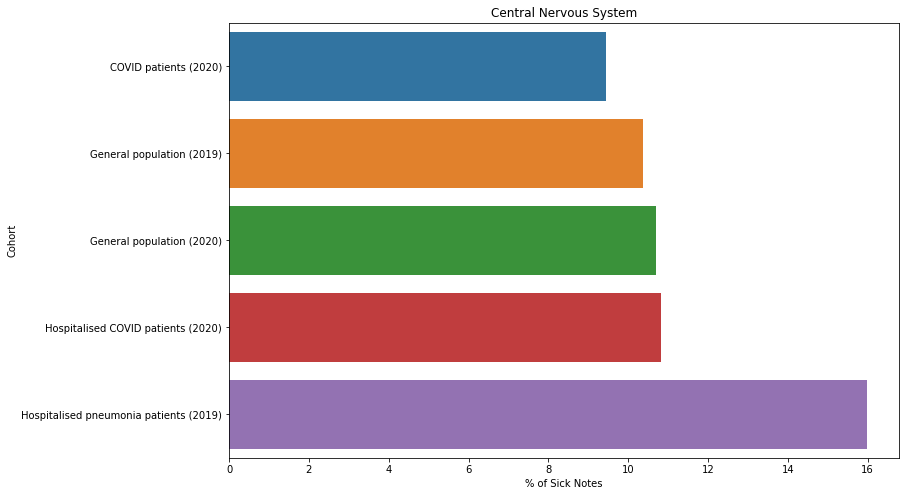

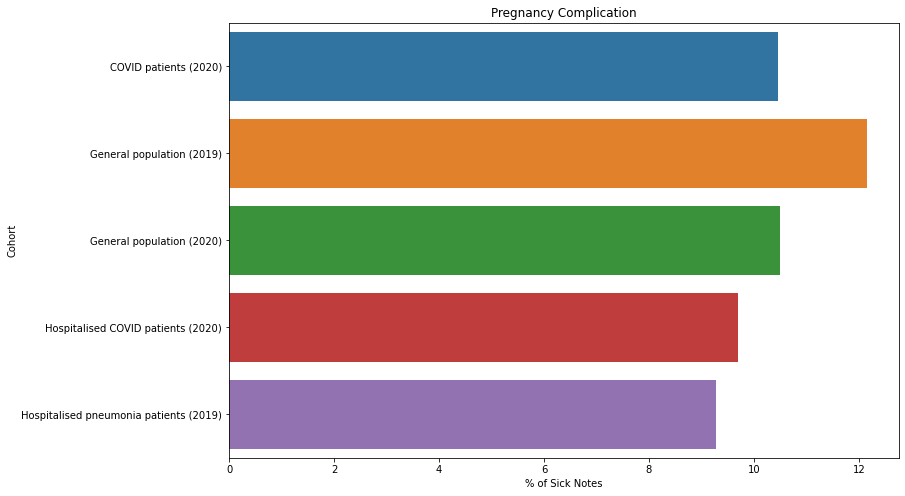

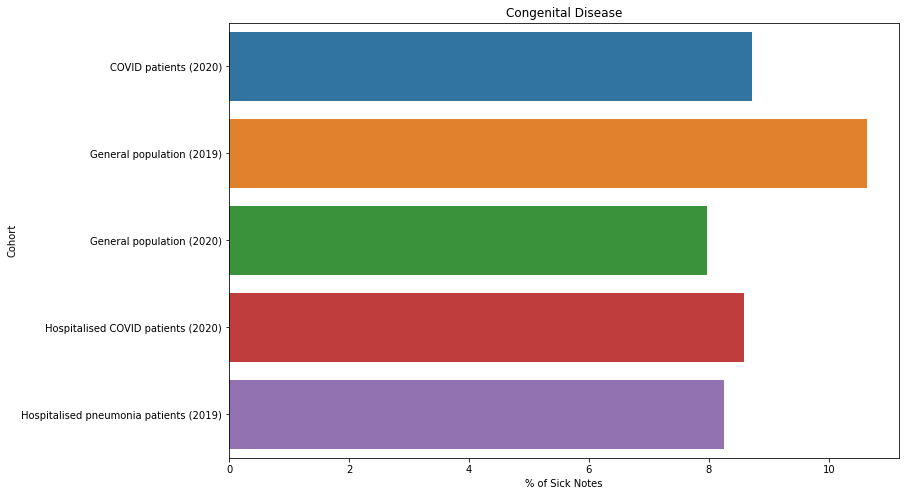

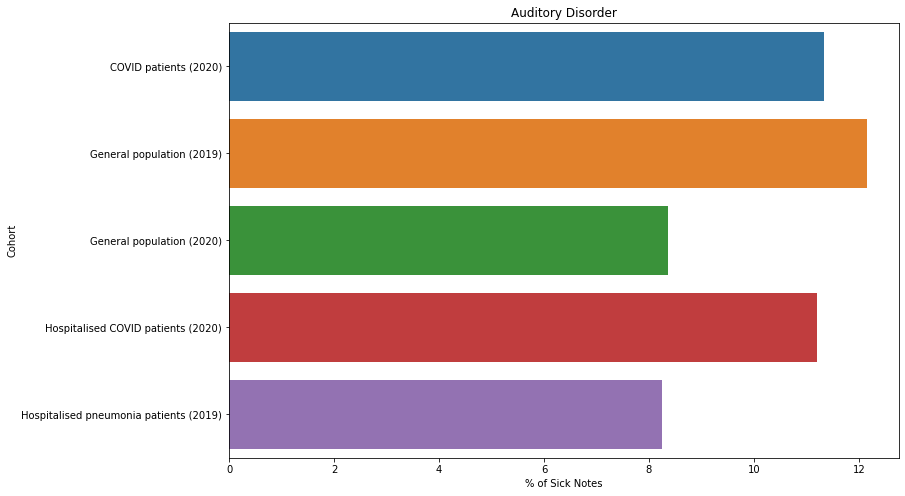

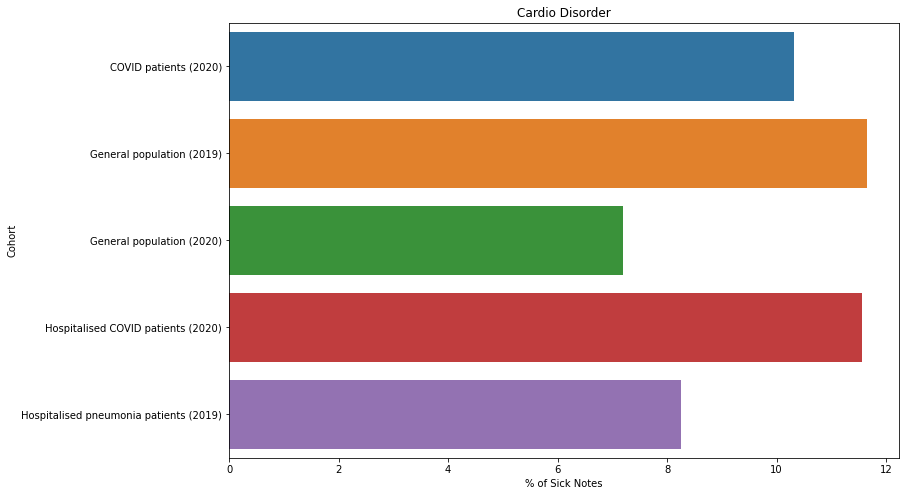

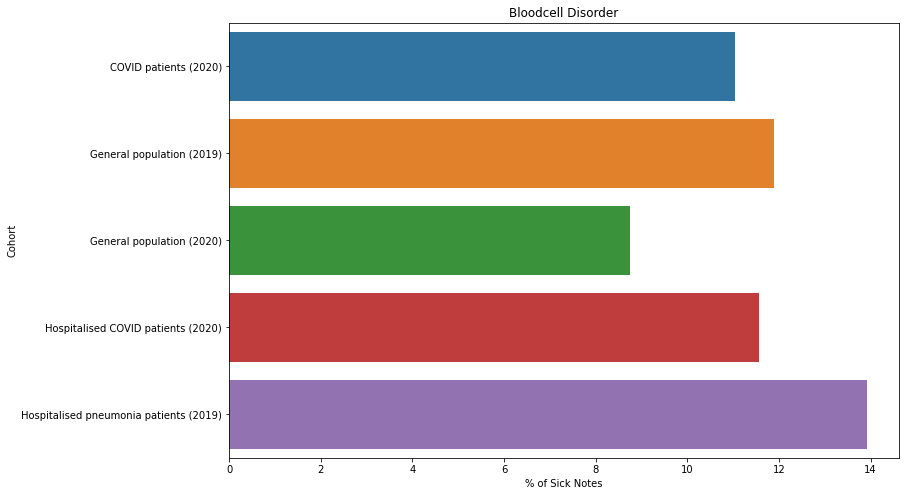

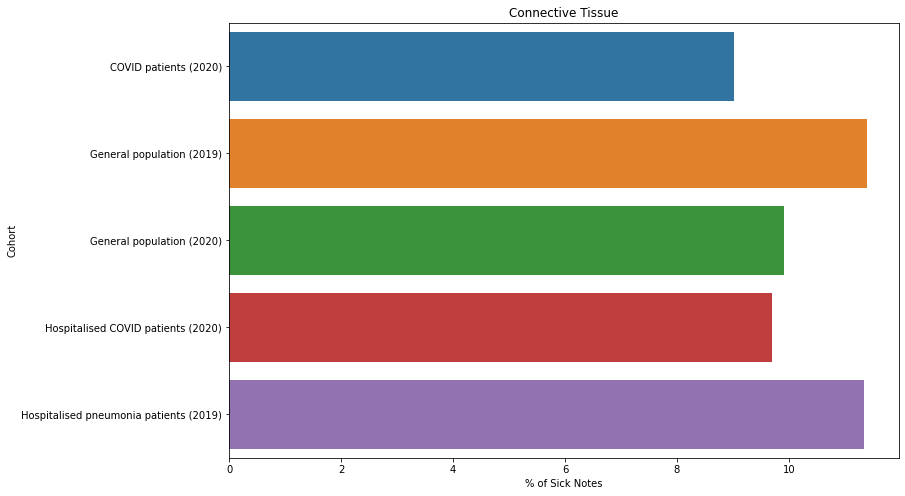

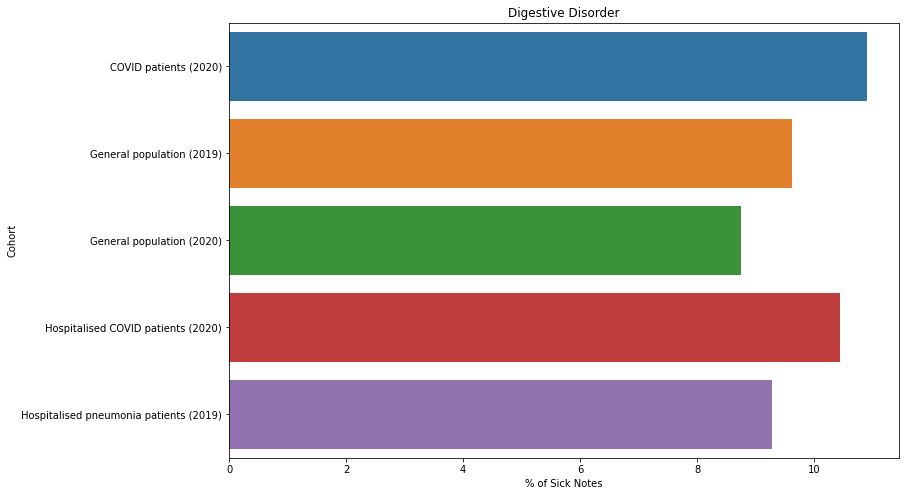

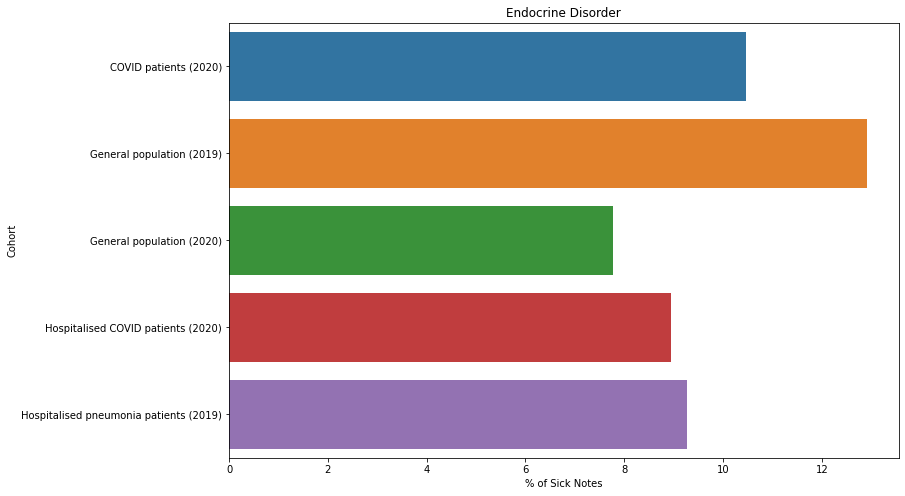

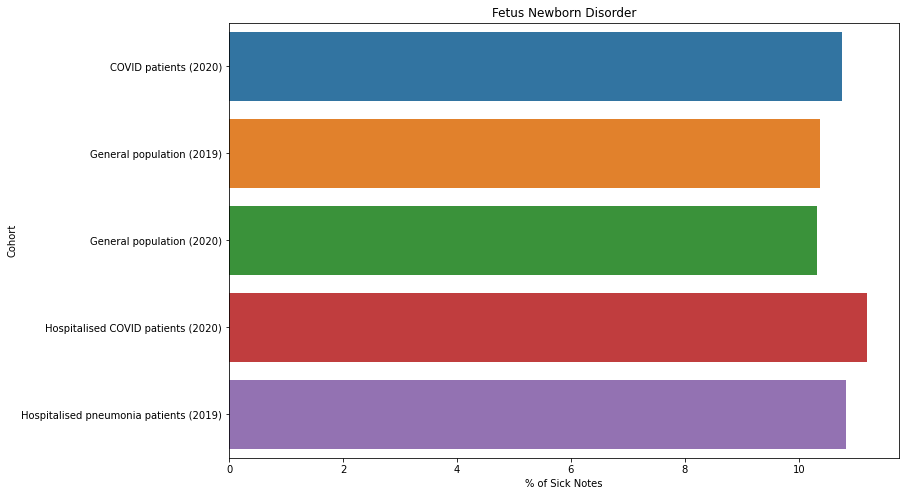

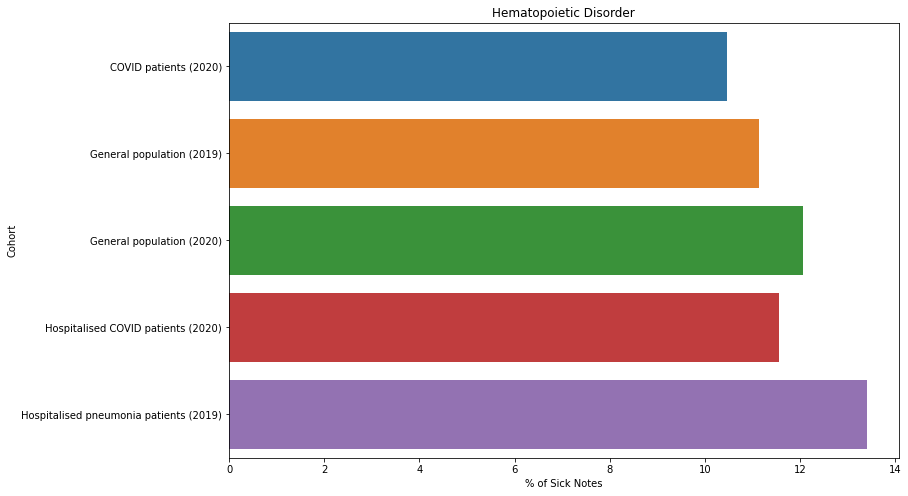

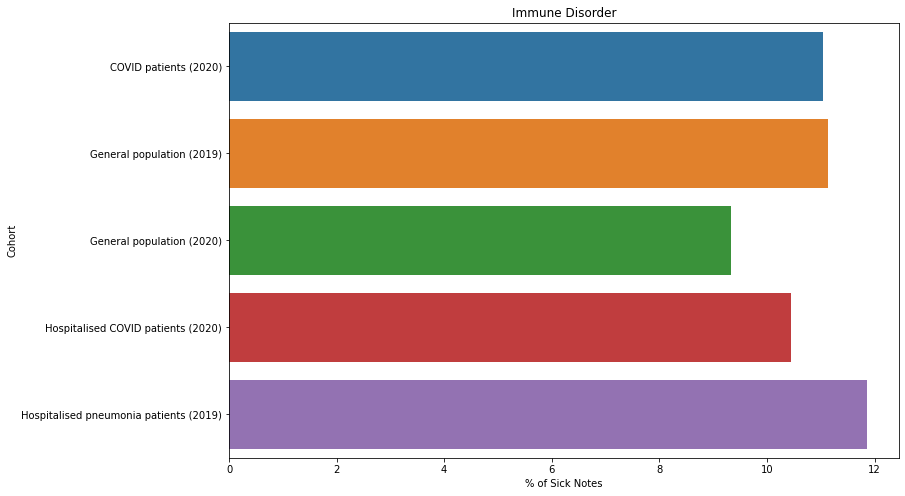

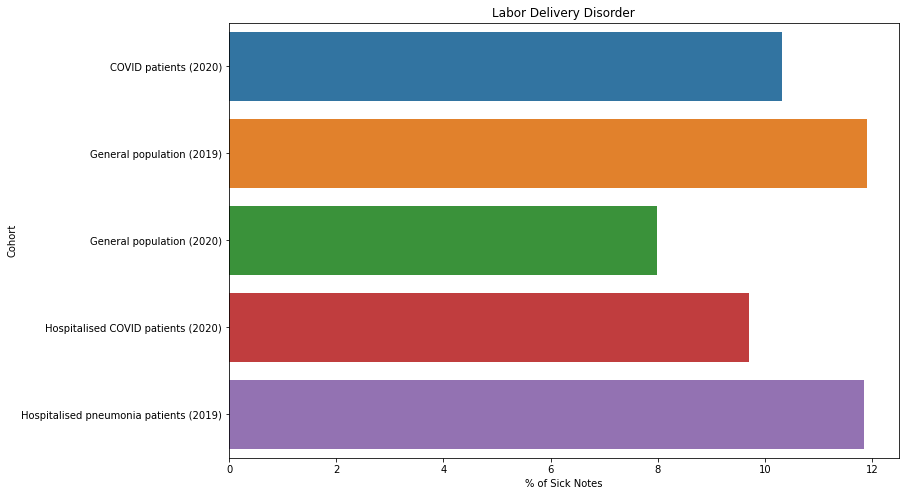

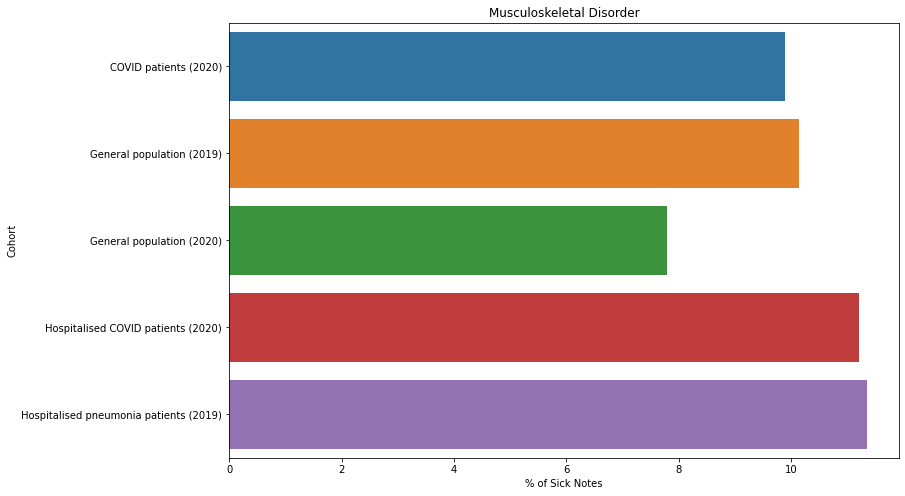

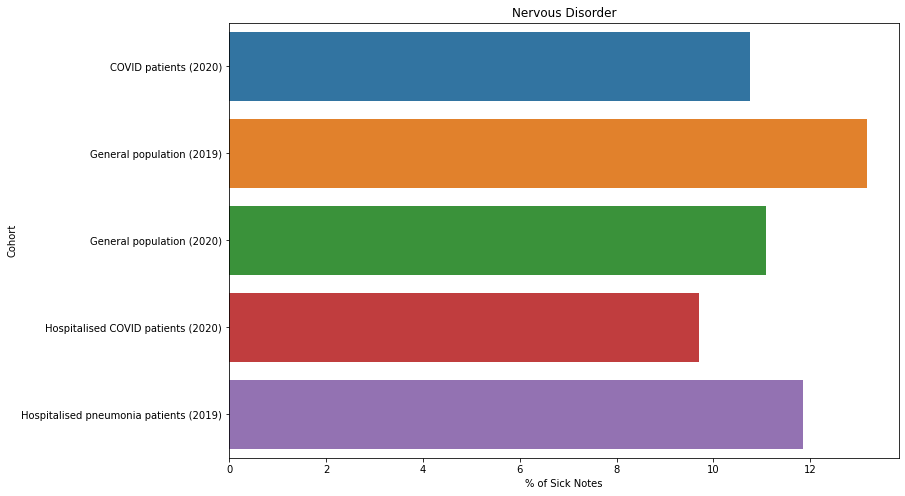

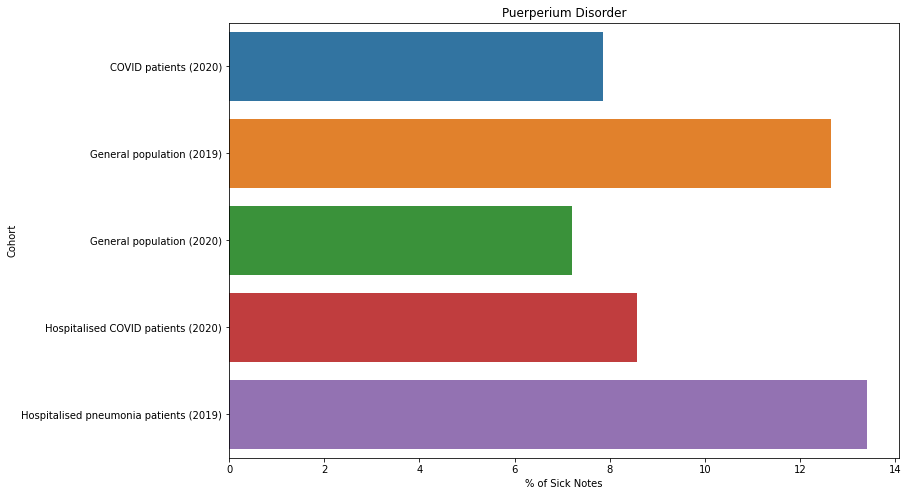

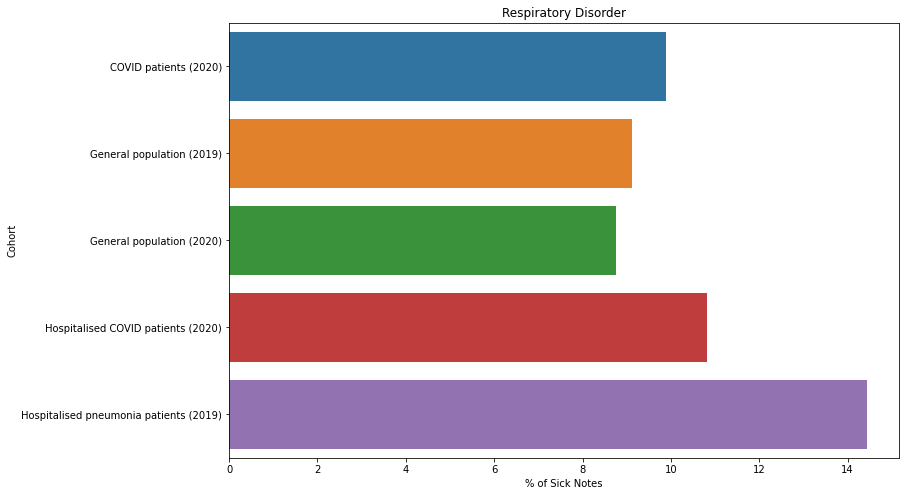

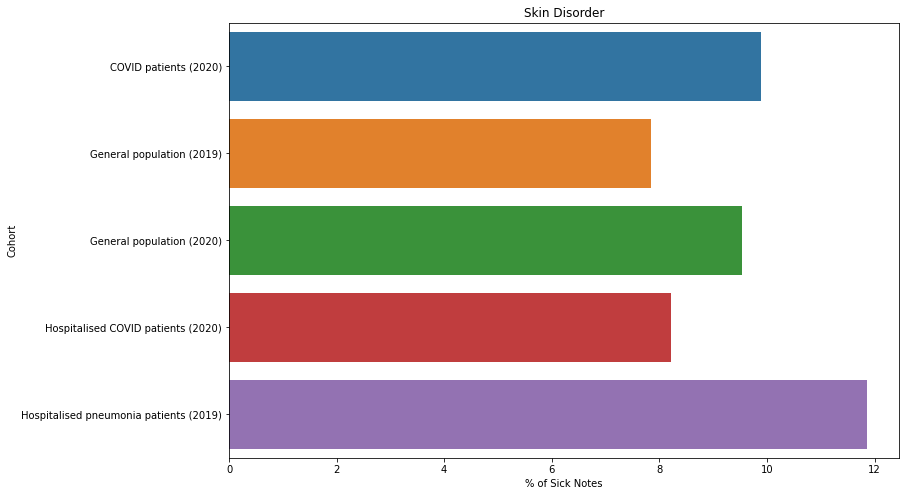

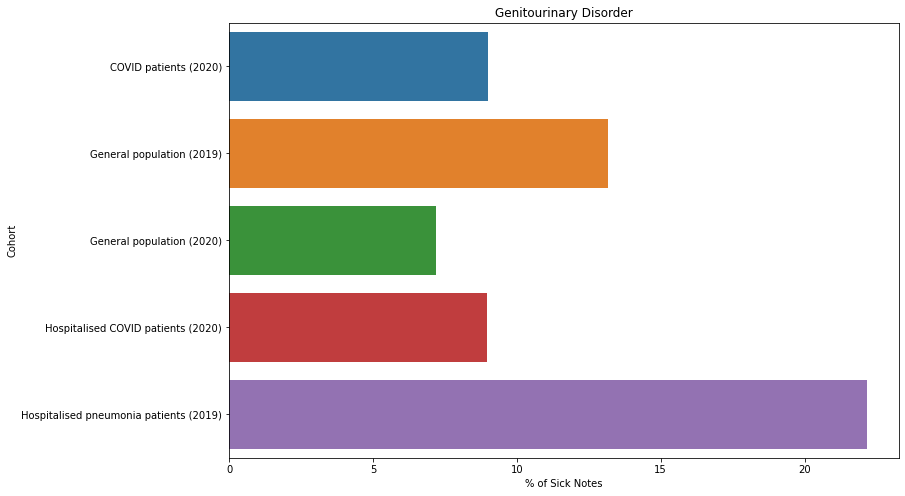

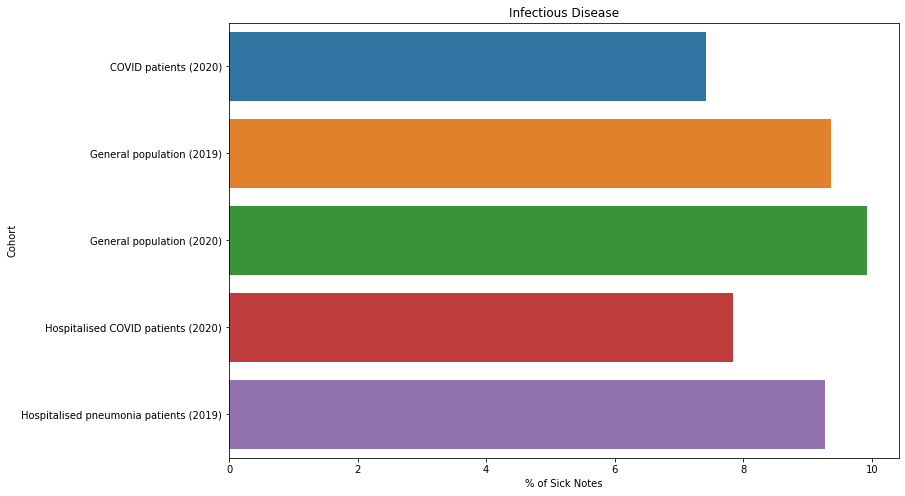

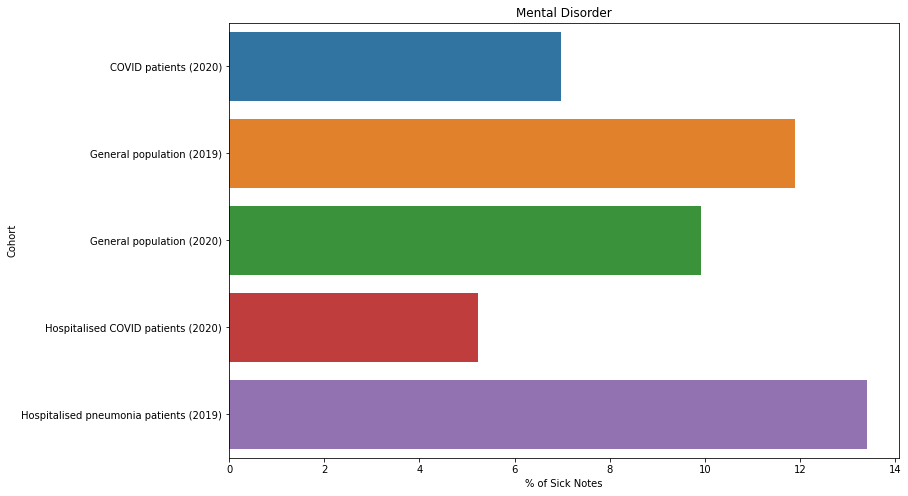

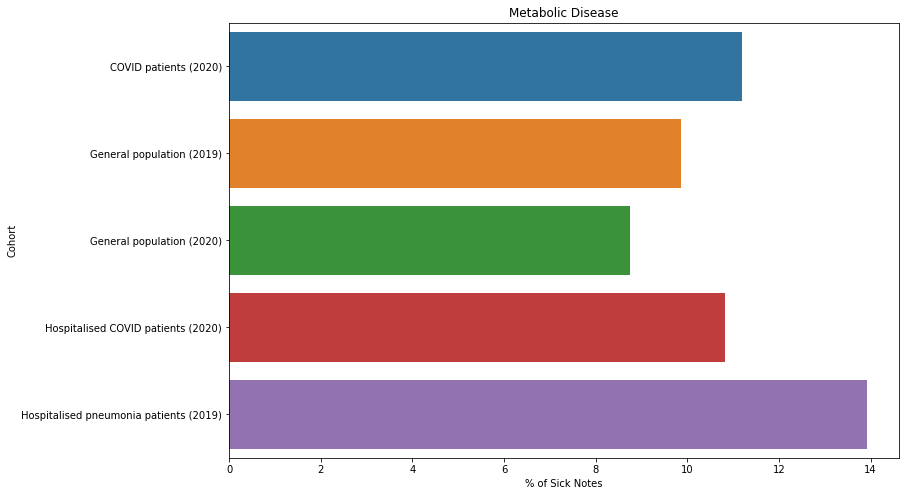

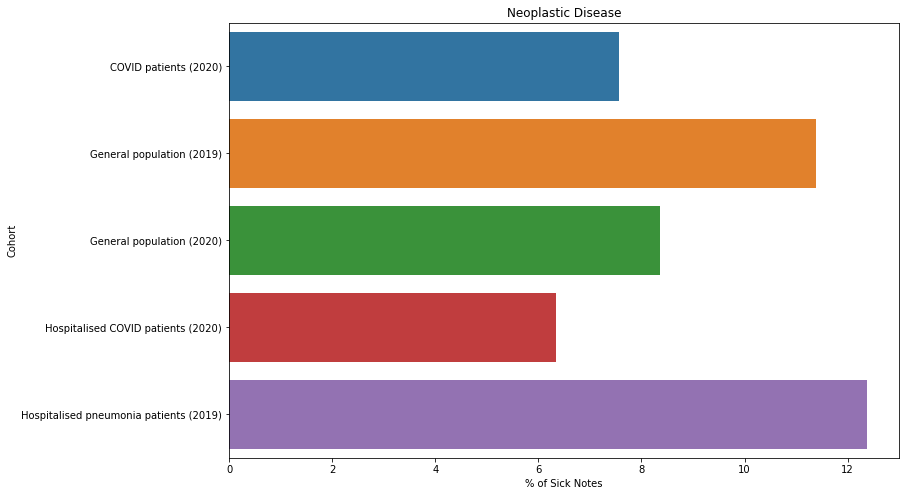

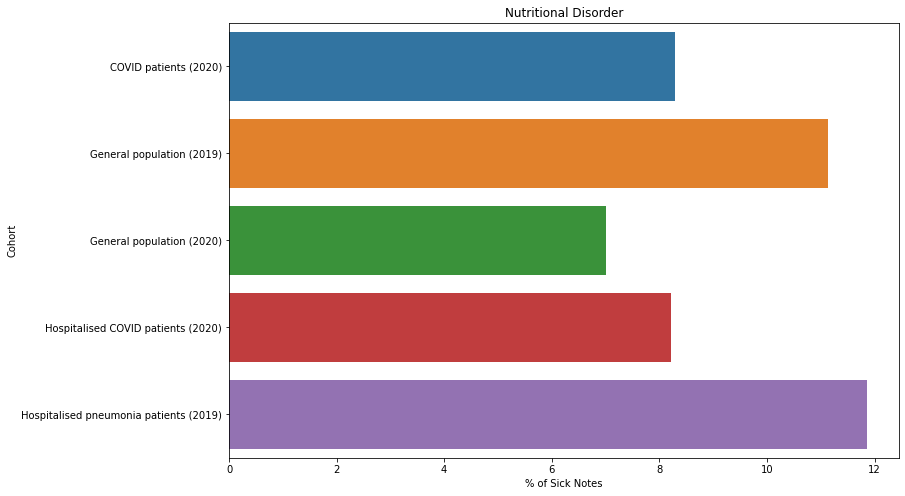

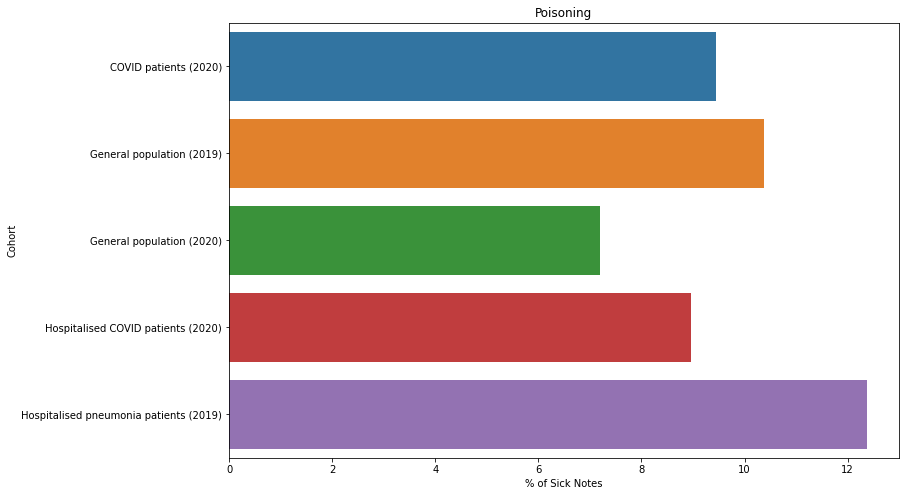

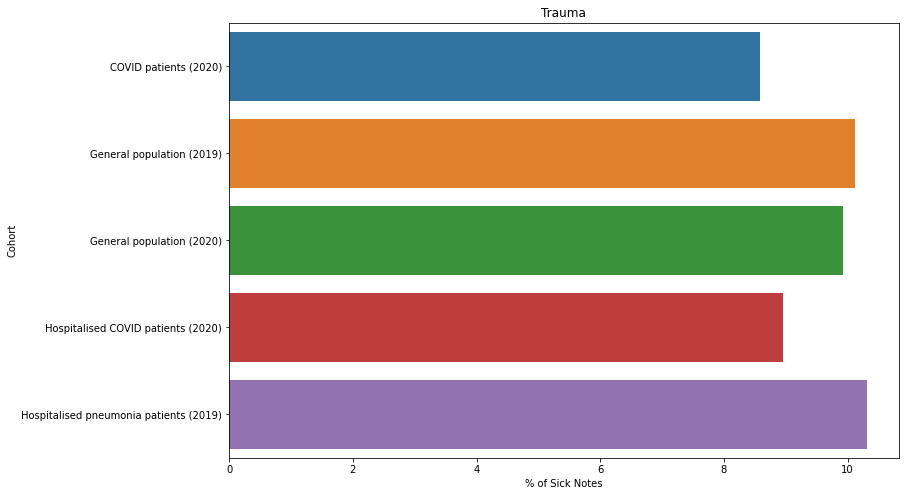

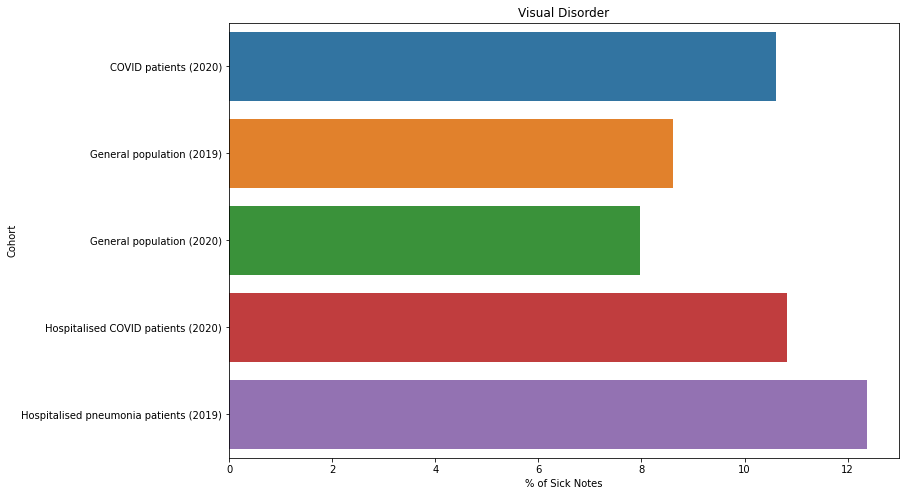

In [16]:
for c in diag_cols:
    # Subset and redact if <= 5 in sick note or diagnosis count
    df_subset = df_diag_sum[['cohort', 'sick_note', 'num_'+c, 'pct_'+c]]
    df_subset = df_subset.loc[(df_subset['sick_note'] > 5) & (df_subset['num_'+c] > 5)]
    try:
        create_plotgrid(c)
    except ValueError:
        pass

### Top Codes by Category

In [17]:
# Map categories to codelists
dict_cat_codes = {
    "diag_central_nervous_system": 'central-nervous-system-finding',
    "diag_pregnancy_complication": 'complication-of-pregnancy-childbirth-andor-the-puerperium',
    "diag_congenital_disease": 'congenital-disease',
    "diag_auditory_disorder": 'disorder-of-auditory-system',
    "diag_cardio_disorder": 'disorder-of-cardiovascular-system',
    "diag_bloodcell_disorder": 'disorder-of-cellular-component-of-blood',
    "diag_connective_tissue": 'disorder-of-connective-tissue',
    "diag_digestive_disorder": 'disorder-of-digestive-system',
    "diag_endocrine_disorder": 'disorder-of-endocrine-system',
    "diag_fetus_newborn_disorder": 'disorder-of-fetus-or-newborn',
    "diag_hematopoietic_disorder": 'disorder-of-hematopoietic-structure',
    "diag_immune_disorder": 'disorder-of-immune-function',
    "diag_labor_delivery_disorder": 'disorder-of-labor-delivery',
    "diag_musculoskeletal_disorder": 'disorder-of-musculoskeletal-system',
    "diag_nervous_disorder": 'disorder-of-nervous-system',
    "diag_puerperium_disorder": 'disorder-of-puerperium',
    "diag_respiratory_disorder": 'disorder-of-respiratory-system',
    "diag_skin_disorder": 'disorder-of-skin-andor-subcutaneous-tissue',
    "diag_genitourinary_disorder": 'disorder-of-the-genitourinary-system',
    "diag_infectious_disease": 'infectious-disease',
    "diag_mental_disorder": 'mental-disorder',
    "diag_metabolic_disease": 'metabolic-disease',
    "diag_neoplastic_disease": 'neoplastic-disease',
    "diag_nutritional_disorder": 'nutritional-disorder',
    "diag_poisoning": 'poisoning',
    "diag_trauma": 'traumatic-andor-non-traumatic-injury',
    "diag_visual_disorder": 'visual-system-disorder',
}

In [18]:
# Import codelist to get codenames
def import_codelist(measure):
    fname = dict_cat_codes.get(measure)
    df_codelist = pd.read_csv(f'../codelists/user-kate-mansfield-{fname}-all-descendants.csv')
    return df_codelist

In [19]:
def top_codes(measure):
    # Sum by code
    df_cln_codes = df_clean[['cohort',measure,'population']].rename(columns={'population':'count',measure:'code'})
    df_cln_codes_agg = df_cln_codes.groupby(['cohort','code']).sum().reset_index()

    # Add code names
    df_codelist = import_codelist(measure)
    df_code_sum = df_cln_codes_agg.merge(df_codelist, on='code', how='left')

    # Restrict to top 5 (redact if count <= 5)
    df_code_sum = df_code_sum.sort_values(['cohort','count'],ascending=False).groupby(['cohort','code']).head(5).reset_index(drop=True)
    df_code_sum = df_code_sum.loc[df_code_sum['count'] > 5]
    df_code_sum = df_code_sum[['cohort','code','term','count']].reset_index(drop=True)

    # Display
    title = measure[5:].replace("_", " ").title()
    df_code_sum = df_code_sum.style.set_caption(f'Top Codes ({title})')
    display(df_code_sum)
    print('\n')

In [20]:
for c in diag_cols:
    top_codes(c)

,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,13
1,Hospitalised COVID patients (2020),10823571000119104.000000,nan,10
2,Hospitalised COVID patients (2020),106010004.000000,nan,8
3,Hospitalised COVID patients (2020),1010442006.000000,nan,6
4,General population (2020),106010004.000000,nan,15
5,General population (2020),10294000.000000,nan,13
6,General population (2020),1010442006.000000,nan,11
7,General population (2020),1048491000000106.000000,nan,9
8,General population (2020),10823571000119104.000000,nan,7
9,General population (2019),106010004.000000,nan,14


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,Pelvic dystocia AND/OR uterine disorder,8
1,Hospitalised COVID patients (2020),106010004.000000,Pelvic dystocia AND/OR uterine disorder,7
2,Hospitalised COVID patients (2020),1010442006.000000,nan,7
3,Hospitalised COVID patients (2020),10294000.000000,nan,6
4,General population (2020),106010004.000000,Pelvic dystocia AND/OR uterine disorder,20
5,General population (2020),1010442006.000000,nan,13
6,General population (2020),10823571000119104.000000,nan,11
7,General population (2020),10294000.000000,nan,8
8,General population (2019),106010004.000000,Pelvic dystocia AND/OR uterine disorder,12
9,General population (2019),1010442006.000000,nan,12


,cohort,code,term,count
0,General population (2020),106010004.000000,nan,17
1,General population (2020),10294000.000000,nan,7
2,General population (2020),1010442006.000000,nan,6
3,General population (2020),1048491000000106.000000,nan,6
4,General population (2019),106010004.000000,nan,13
5,General population (2019),10294000.000000,nan,11
6,General population (2019),1010442006.000000,nan,8
7,General population (2019),10823571000119104.000000,nan,8
8,COVID patients (2020),106010004.000000,nan,16
9,COVID patients (2020),1010442006.000000,nan,15


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,7
1,Hospitalised COVID patients (2020),106010004.000000,nan,10
2,Hospitalised COVID patients (2020),1010442006.000000,Sensorineural hearing loss of left ear with normal hearing on right side,6
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
4,General population (2020),1010442006.000000,Sensorineural hearing loss of left ear with normal hearing on right side,13
5,General population (2020),106010004.000000,nan,11
6,General population (2020),10823571000119104.000000,nan,10
7,General population (2020),10294000.000000,nan,8
8,General population (2019),106010004.000000,nan,20
9,General population (2019),1010442006.000000,Sensorineural hearing loss of left ear with normal hearing on right side,9


,cohort,code,term,count
0,Hospitalised COVID patients (2020),10294000.000000,nan,10
1,Hospitalised COVID patients (2020),106010004.000000,nan,10
2,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
3,General population (2020),106010004.000000,nan,14
4,General population (2020),10294000.000000,nan,8
5,General population (2020),10823571000119104.000000,nan,6
6,General population (2019),106010004.000000,nan,12
7,General population (2019),10294000.000000,nan,10
8,General population (2019),10823571000119104.000000,nan,10
9,General population (2019),1010442006.000000,nan,9


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,Hospitalised pneumonia patients (2019),1010442006.000000,nan,8
2,Hospitalised COVID patients (2020),106010004.000000,nan,12
3,Hospitalised COVID patients (2020),1010442006.000000,nan,7
4,General population (2020),106010004.000000,nan,18
5,General population (2020),10823571000119104.000000,nan,11
6,General population (2020),10294000.000000,Reactive mastocytosis,8
7,General population (2019),106010004.000000,nan,22
8,General population (2019),10294000.000000,Reactive mastocytosis,11
9,General population (2019),1010442006.000000,nan,9


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,6
1,Hospitalised COVID patients (2020),106010004.000000,nan,7
2,Hospitalised COVID patients (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,7
3,Hospitalised COVID patients (2020),1010442006.000000,nan,6
4,General population (2020),106010004.000000,nan,12
5,General population (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,12
6,General population (2020),1010442006.000000,nan,11
7,General population (2020),10294000.000000,nan,9
8,General population (2020),1048491000000106.000000,nan,7
9,General population (2019),106010004.000000,nan,18


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,6
1,Hospitalised COVID patients (2020),10823571000119104.000000,nan,8
2,Hospitalised COVID patients (2020),1048491000000106.000000,nan,7
3,Hospitalised COVID patients (2020),106010004.000000,nan,6
4,General population (2020),1010442006.000000,nan,11
5,General population (2020),106010004.000000,nan,10
6,General population (2020),10294000.000000,nan,9
7,General population (2020),10823571000119104.000000,nan,9
8,General population (2020),1048491000000106.000000,nan,6
9,General population (2019),10823571000119104.000000,nan,11


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,6
1,Hospitalised COVID patients (2020),106010004.000000,nan,9
2,General population (2020),10823571000119104.000000,nan,10
3,General population (2020),106010004.000000,nan,9
4,General population (2020),1010442006.000000,nan,9
5,General population (2020),10294000.000000,nan,8
6,General population (2019),106010004.000000,nan,14
7,General population (2019),10823571000119104.000000,nan,13
8,General population (2019),1010442006.000000,nan,11
9,General population (2019),1048491000000106.000000,nan,7


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,Hospitalised COVID patients (2020),10294000.000000,nan,9
2,Hospitalised COVID patients (2020),106010004.000000,nan,8
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,7
4,General population (2020),106010004.000000,nan,16
5,General population (2020),1010442006.000000,nan,14
6,General population (2020),10294000.000000,nan,11
7,General population (2020),10823571000119104.000000,nan,8
8,General population (2019),106010004.000000,nan,13
9,General population (2019),10294000.000000,nan,8


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,Hospitalised pneumonia patients (2019),10294000.000000,Reactive mastocytosis,7
2,Hospitalised pneumonia patients (2019),10823571000119104.000000,nan,7
3,Hospitalised COVID patients (2020),106010004.000000,nan,8
4,Hospitalised COVID patients (2020),1010442006.000000,nan,8
5,Hospitalised COVID patients (2020),10294000.000000,Reactive mastocytosis,6
6,General population (2020),10823571000119104.000000,nan,18
7,General population (2020),106010004.000000,nan,16
8,General population (2020),10294000.000000,Reactive mastocytosis,13
9,General population (2020),1010442006.000000,nan,9


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,Hospitalised COVID patients (2020),106010004.000000,nan,9
2,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
3,General population (2020),106010004.000000,nan,19
4,General population (2020),1010442006.000000,nan,11
5,General population (2020),10294000.000000,Reactive mastocytosis,8
6,General population (2020),10823571000119104.000000,nan,8
7,General population (2019),10294000.000000,Reactive mastocytosis,12
8,General population (2019),106010004.000000,nan,12
9,General population (2019),1010442006.000000,nan,11


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,Pelvic dystocia AND/OR uterine disorder,7
1,Hospitalised COVID patients (2020),106010004.000000,Pelvic dystocia AND/OR uterine disorder,9
2,Hospitalised COVID patients (2020),10294000.000000,nan,6
3,General population (2020),1010442006.000000,nan,13
4,General population (2020),106010004.000000,Pelvic dystocia AND/OR uterine disorder,12
5,General population (2020),10294000.000000,nan,8
6,General population (2019),106010004.000000,Pelvic dystocia AND/OR uterine disorder,14
7,General population (2019),1010442006.000000,nan,11
8,General population (2019),10823571000119104.000000,nan,11
9,General population (2019),10294000.000000,nan,10


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,8
1,Hospitalised pneumonia patients (2019),1010442006.000000,nan,6
2,Hospitalised COVID patients (2020),106010004.000000,nan,14
3,Hospitalised COVID patients (2020),10294000.000000,nan,8
4,Hospitalised COVID patients (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,6
5,General population (2020),106010004.000000,nan,15
6,General population (2020),1010442006.000000,nan,10
7,General population (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,7
8,General population (2020),10294000.000000,nan,6
9,General population (2019),10294000.000000,nan,11


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,11
1,Hospitalised pneumonia patients (2019),1010442006.000000,nan,7
2,Hospitalised COVID patients (2020),106010004.000000,nan,8
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,7
4,Hospitalised COVID patients (2020),1010442006.000000,nan,6
5,General population (2020),106010004.000000,nan,22
6,General population (2020),1010442006.000000,nan,14
7,General population (2020),10823571000119104.000000,nan,12
8,General population (2019),1010442006.000000,nan,16
9,General population (2019),106010004.000000,nan,15


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10294000.000000,nan,9
1,Hospitalised pneumonia patients (2019),1010442006.000000,nan,6
2,Hospitalised COVID patients (2020),10294000.000000,nan,6
3,Hospitalised COVID patients (2020),106010004.000000,nan,6
4,General population (2020),106010004.000000,nan,10
5,General population (2020),10823571000119104.000000,nan,10
6,General population (2020),10294000.000000,nan,9
7,General population (2020),1010442006.000000,nan,6
8,General population (2019),10294000.000000,nan,13
9,General population (2019),106010004.000000,nan,13


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006.000000,nan,9
1,Hospitalised pneumonia patients (2019),106010004.000000,nan,6
2,Hospitalised COVID patients (2020),106010004.000000,nan,9
3,Hospitalised COVID patients (2020),10294000.000000,nan,7
4,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
5,General population (2020),106010004.000000,nan,12
6,General population (2020),10823571000119104.000000,nan,12
7,General population (2020),1010442006.000000,nan,8
8,General population (2020),10294000.000000,nan,7
9,General population (2020),1048491000000106.000000,nan,6


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006.000000,nan,7
1,Hospitalised COVID patients (2020),106010004.000000,nan,12
2,General population (2020),106010004.000000,nan,17
3,General population (2020),10823571000119104.000000,nan,14
4,General population (2020),1010442006.000000,nan,9
5,General population (2020),10294000.000000,nan,7
6,General population (2019),10294000.000000,nan,7
7,General population (2019),1010442006.000000,nan,7
8,General population (2019),106010004.000000,nan,6
9,General population (2019),10823571000119104.000000,nan,6


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006.000000,nan,12
1,Hospitalised pneumonia patients (2019),106010004.000000,nan,10
2,Hospitalised pneumonia patients (2019),1048491000000106.000000,Acute kidney injury due to acute tubular necrosis due to sepsis,8
3,Hospitalised pneumonia patients (2019),10294000.000000,nan,7
4,Hospitalised pneumonia patients (2019),10823571000119104.000000,nan,6
5,Hospitalised COVID patients (2020),10294000.000000,nan,8
6,General population (2020),10294000.000000,nan,13
7,General population (2020),106010004.000000,nan,10
8,General population (2020),10823571000119104.000000,nan,7
9,General population (2019),10823571000119104.000000,nan,15


,cohort,code,term,count
0,Hospitalised COVID patients (2020),10294000.000000,nan,9
1,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
2,General population (2020),1010442006.000000,nan,17
3,General population (2020),106010004.000000,nan,15
4,General population (2020),10294000.000000,nan,9
5,General population (2020),10823571000119104.000000,nan,9
6,General population (2019),106010004.000000,nan,11
7,General population (2019),1010442006.000000,nan,10
8,General population (2019),10294000.000000,nan,9
9,General population (2019),10823571000119104.000000,nan,6


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,General population (2020),106010004.000000,nan,17
2,General population (2020),10294000.000000,nan,10
3,General population (2020),10823571000119104.000000,nan,9
4,General population (2020),1048491000000106.000000,nan,8
5,General population (2020),1010442006.000000,nan,7
6,General population (2019),106010004.000000,nan,18
7,General population (2019),10294000.000000,nan,15
8,General population (2019),1010442006.000000,nan,7
9,General population (2019),10823571000119104.000000,nan,6


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,11
1,Hospitalised COVID patients (2020),1010442006.000000,nan,9
2,Hospitalised COVID patients (2020),106010004.000000,nan,7
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,7
4,General population (2020),106010004.000000,nan,14
5,General population (2020),10294000.000000,nan,11
6,General population (2020),1010442006.000000,nan,10
7,General population (2020),10823571000119104.000000,nan,9
8,General population (2019),1048491000000106.000000,nan,10
9,General population (2019),10294000.000000,nan,9


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10823571000119104.000000,nan,9
1,General population (2020),106010004.000000,nan,16
2,General population (2020),10294000.000000,nan,12
3,General population (2020),1010442006.000000,nan,6
4,General population (2019),106010004.000000,nan,18
5,General population (2019),10823571000119104.000000,nan,10
6,General population (2019),1010442006.000000,nan,7
7,General population (2019),1048491000000106.000000,nan,7
8,COVID patients (2020),106010004.000000,nan,14
9,COVID patients (2020),10823571000119104.000000,nan,13


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,8
1,Hospitalised pneumonia patients (2019),10823571000119104.000000,nan,7
2,Hospitalised COVID patients (2020),106010004.000000,nan,9
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,6
4,General population (2020),106010004.000000,nan,12
5,General population (2020),10823571000119104.000000,nan,8
6,General population (2020),1010442006.000000,nan,7
7,General population (2019),106010004.000000,nan,12
8,General population (2019),1010442006.000000,nan,11
9,General population (2019),10823571000119104.000000,nan,11


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),1010442006.000000,nan,12
1,Hospitalised COVID patients (2020),10294000.000000,nan,7
2,Hospitalised COVID patients (2020),1010442006.000000,nan,6
3,General population (2020),106010004.000000,nan,11
4,General population (2020),1010442006.000000,nan,11
5,General population (2020),10823571000119104.000000,nan,7
6,General population (2019),10294000.000000,nan,12
7,General population (2019),106010004.000000,nan,9
8,General population (2019),1010442006.000000,nan,9
9,General population (2019),10823571000119104.000000,nan,8


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),106010004.000000,nan,9
1,Hospitalised COVID patients (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,9
2,Hospitalised COVID patients (2020),106010004.000000,nan,7
3,General population (2020),10294000.000000,nan,18
4,General population (2020),106010004.000000,nan,11
5,General population (2020),1010442006.000000,nan,10
6,General population (2020),1048491000000106.000000,nan,6
7,General population (2020),10823571000119104.000000,Open mallet fracture of distal phalanx of ring finger of left hand,6
8,General population (2019),106010004.000000,nan,16
9,General population (2019),1010442006.000000,nan,12


,cohort,code,term,count
0,Hospitalised pneumonia patients (2019),10294000.000000,nan,9
1,Hospitalised pneumonia patients (2019),1010442006.000000,nan,8
2,Hospitalised COVID patients (2020),106010004.000000,nan,11
3,Hospitalised COVID patients (2020),10823571000119104.000000,nan,7
4,Hospitalised COVID patients (2020),10294000.000000,nan,6
5,General population (2020),106010004.000000,nan,17
6,General population (2020),1010442006.000000,nan,8
7,General population (2020),10823571000119104.000000,nan,7
8,General population (2019),106010004.000000,nan,13
9,General population (2019),1010442006.000000,nan,11
